---
title: Tutorial - Formatting an sbml_dfs as a cpr_graph"
author: "Shackett"
date: "May 9th 2025"
---

`sbml_dfs` objects are stand-alone representations of pathways but they need to be formatted as a `cpr_graph` object if we want to use them as a network. Doing this will allow us to translate a range of biological questions into network operations - see **suggesting_mechanisms_with_networks.qmd**.

Here, we will go through the process of translating pathways into graphs and how to precompute distances between molecular species (to speed up search). Its at this stage that we can also add high-dimensional data to our graph but that is discussed as a separate vignette - **adding_data_to_graphs.qmd**.

In [4]:
#| label: config

import logging

import seaborn as sns

from napistu import utils 
from napistu.network import net_create
from napistu.network import precompute

import tutorial_utils

logger = logging.getLogger()
logger.setLevel("INFO")

config = tutorial_utils.NapistuConfig("config.yaml", "formatting_sbml_dfs_as_cpr_graphs")

## Load an `sbml_dfs` pathway representation

A `sbml_dfs`, further described in the `understanding_sbml_dfs.qmd` vignette, is a stand-alone representation of a pathway. Here, we load a pickled `sbml_dfs` object that we will use to create a `cpr_graph`. The model here was created from a few metabolic pathways from Reactome merged into a consensus model.

In [5]:
#| label: load_data

sbml_dfs_path = config.load_asset("test_pathway", "sbml_dfs")
sbml_dfs = utils.load_pickle(sbml_dfs_path)

## Create a Network

CPR's strategy for translating an `sbml_dfs` object into a graph is thoroughly described in the  [CPR Wiki - CPR Graphs](https://github.com/calico/Open-CPR/wiki/CPR-Graphs). Briefly, we can create a graph using a single function `process_cpr_graph` which creates and weights the network or we can divide these calls up by `igraph_network` and `add_graph_weights`.

Here, we will create a network using the `regulatory` graph specification which places an appropriate hierarchy over molecules participating in the same reaction so for instance an enzyme will be upstream of its substrate (since the enzyme regulates the substrate not the other way around). We'll also create a directed graph since the `sbml_dfs` pertains to a metabolic pathway where directionality can be appropriately inferred from reaction stoichiometry.

In [6]:
#| label: sbml_dfs_to_cpr
cpr_graph = net_create.process_cpr_graph(
  sbml_dfs,
  graph_type = "regulatory",
  directed = True
)

INFO:root:Constructing network
INFO:napistu.network.net_create:Organizing all network nodes (compartmentalized species and reactions)
INFO:napistu.network.net_create:Formatting edges as a regulatory graph
INFO:napistu.network.net_create:Formatting 339 reactions species as tiered edges.
INFO:napistu.network.net_create:Adding additional attributes to edges, e.g., # of children and parents.
INFO:napistu.network.net_create:Done preparing regulatory graph
INFO:napistu.network.net_create:Adding reversibility and other meta-data from reactions_data
INFO:napistu.network.net_create:No reactions annotations provided in "graph_attrs"; returning None
INFO:napistu.network.net_create:Creating reverse reactions for reversible reactions on a directed graph
INFO:napistu.network.net_create:Formatting cpr_graph output
INFO:root:Adding edge weights with an unweighted strategy


## Inspecting the Network

The `cpr_graph` is really just an `igraph` `Graph` object with some specific vertex and edge attributes. Let's take a look at the vertices and edges. To make this easier we'll do this in a tabular format.

In [7]:
#| label: graph_to_dfs

from napistu.network import net_utils
vertices, edges = net_utils.cpr_graph_to_pandas_dfs(cpr_graph)

### Vertices: Genes, Metabolites, Reactions, ...

In [8]:
#| label: vertices
utils.style_df(vertices.head())

,index,name,node_name,node_type
0,0,SC00000000,MDH2 dimer [mitochondrial matrix],species
1,1,SC00000001,NAD+ [mitochondrial matrix],species
2,2,SC00000002,NAD+ [cytosol],species
3,3,SC00000003,MAL [mitochondrial matrix],species
4,4,SC00000004,MAL [cytosol],species


### Edges: Linking Pairs of Vertices

In [9]:
#| label: edges
utils.style_df(vertices.head())

,index,name,node_name,node_type
0,0,SC00000000,MDH2 dimer [mitochondrial matrix],species
1,1,SC00000001,NAD+ [mitochondrial matrix],species
2,2,SC00000002,NAD+ [cytosol],species
3,3,SC00000003,MAL [mitochondrial matrix],species
4,4,SC00000004,MAL [cytosol],species


### Network Visualization

The network visualization methods in CPR are better built-out on the R side. But for quick-and-dirty network visualization we can use the standard igraph visualization functions and some plotting wrappers within CPR.

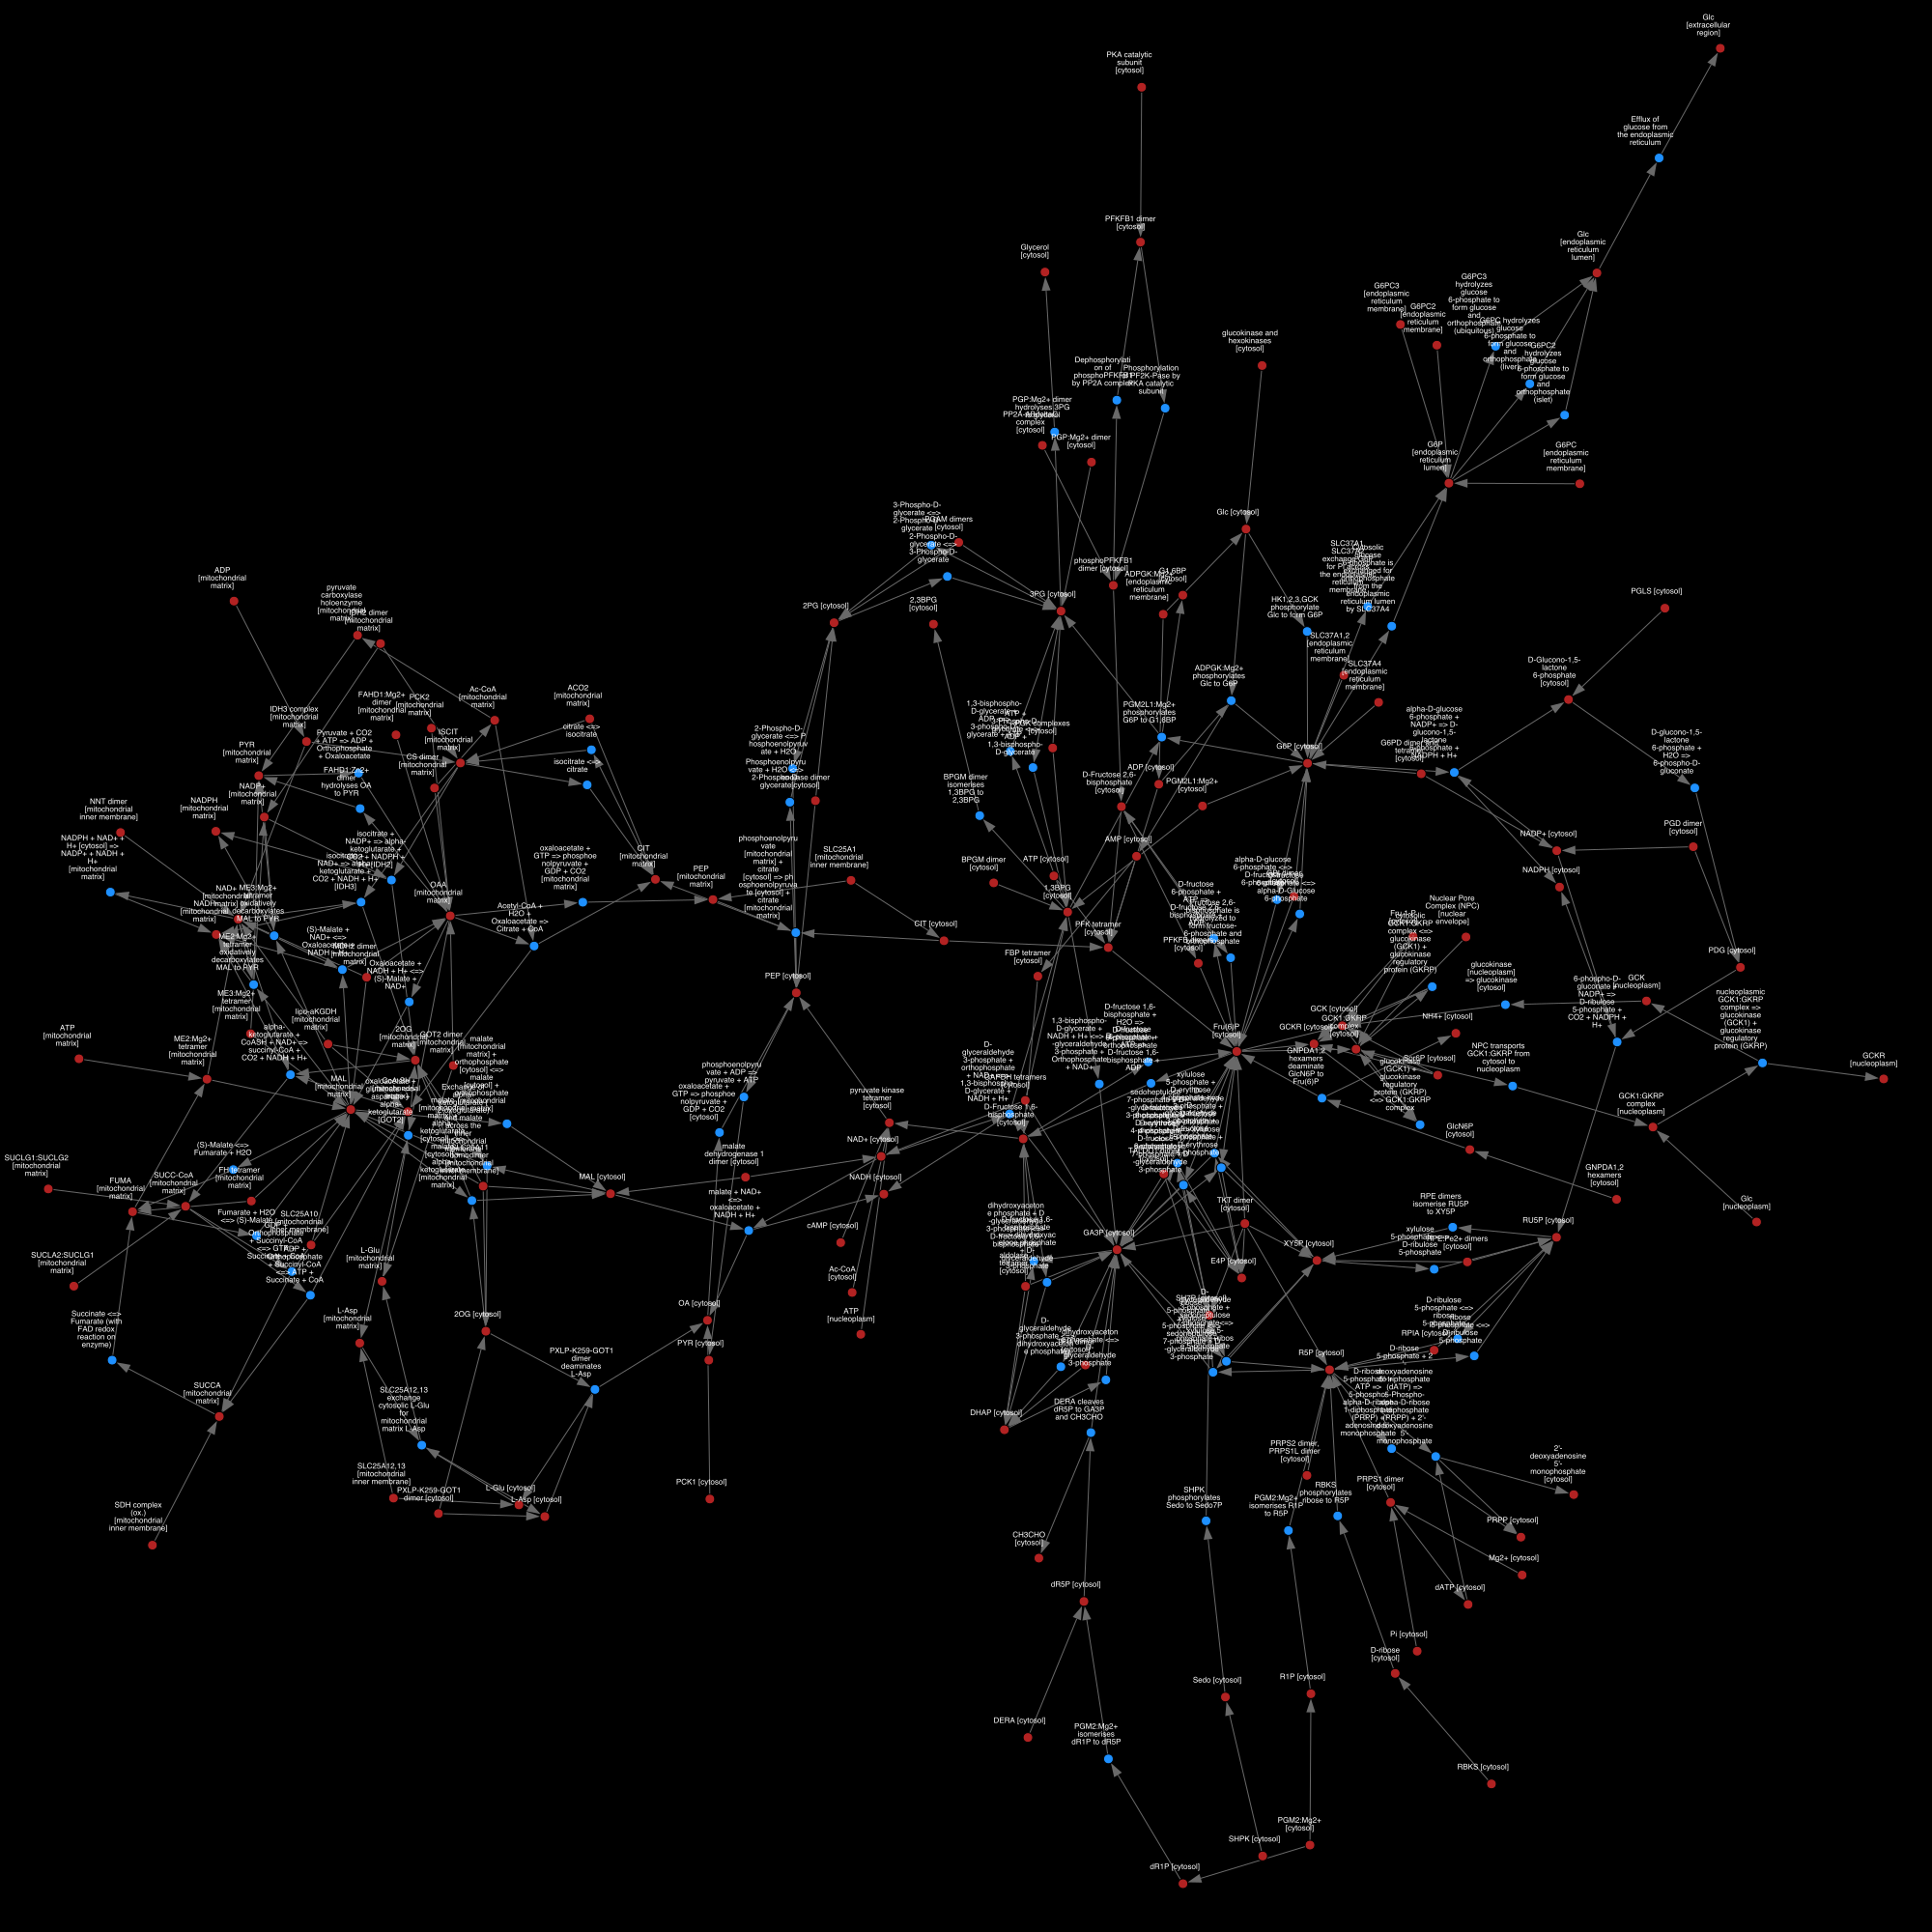

In [10]:
from napistu.network import neighborhoods

neighborhoods.plot_neighborhood(
    net_utils.filter_to_largest_subgraph(cpr_graph),
    name_nodes = True,
    plot_size = 2000,
    network_layout = "kk" 
)

## Precompute Distances

Some network operations can be sped up by precomputing distances between nodes. This is particularly useful for shortest path algorithms. Here we precompute the shortest path distances and weighted shortest paths (if weights are present) between all pairs of nodes in the graph.

In [11]:
#| label: precomputed_distances
distances = precompute.precompute_distances(cpr_graph)

utils.style_df(distances.head(5))

,sc_id_origin,sc_id_dest,path_length,path_upstream_weights,path_weights
1,SC00000000,SC00000001,1.000,1.000,1.000
3,SC00000003,SC00000001,4.000,4.000,4.000
4,SC00000004,SC00000001,6.000,6.000,6.000
5,SC00000005,SC00000001,6.000,6.000,6.000
6,SC00000011,SC00000001,1.000,1.000,1.000


As a quick look into this output we can create a table of the # of steps to progress from source to destination vertices.

<Axes: xlabel='sc_id_dest', ylabel='sc_id_origin'>

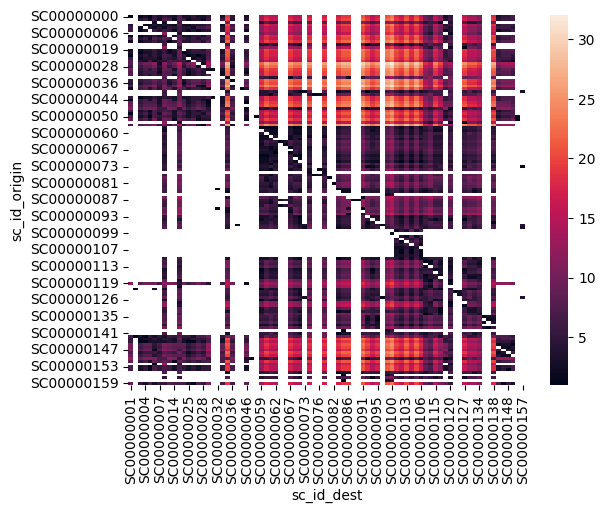

In [ ]:
#| label: plot_precomputed_distance

df = distances.pivot(index='sc_id_origin', columns='sc_id_dest', values='path_length')
sns.heatmap(df, annot=False)